In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.stats
import networkx as nx
import seaborn as sns
import scipy.linalg

In [6]:
def gp2ind(g,p,Np):
    return int(g * Np + p)

def ind2gp(i,Np):
    return (int(i / Np), int(i % Np))

In [7]:
with open('../simulation_results/initial/sim_exp_test.pkl','rb') as file:
    data = pickle.load(file)

In [8]:
data.keys()

dict_keys(['A', 'N', 'T', 'mu', 'c', 'pheno_probs', 'repro_probs', 'trial', 'freq_timeseries', 'Gamma_geno', 'Gamma_pheno'])

In [9]:
Ng,Np = data['pheno_probs'].shape
X = data['repro_probs'] * data['c']

<Axes: >

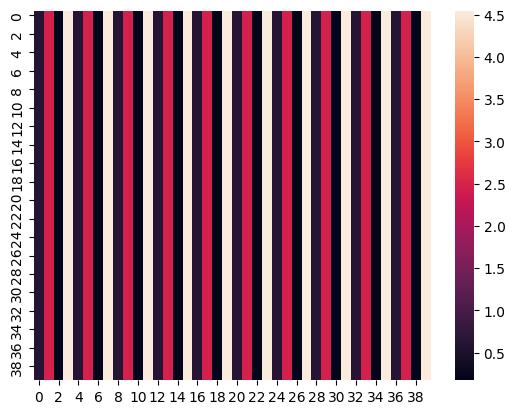

In [10]:
Xk = np.outer(np.ones(Ng*Np),np.ndarray.flatten(np.outer(np.ones((Ng)),X)))
sns.heatmap(Xk)

<Axes: >

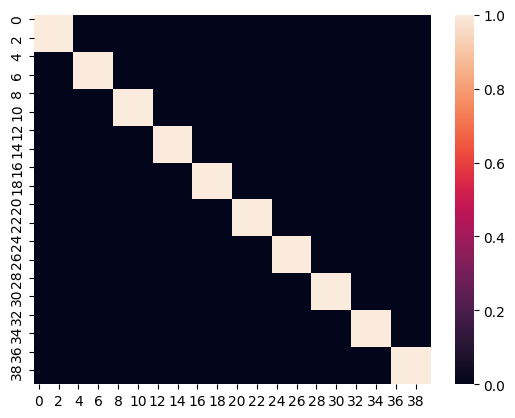

In [11]:
iterable = tuple([np.ones((Np,Np))]*Ng)
block_dirac = scipy.linalg.block_diag(*iterable)
sns.heatmap(block_dirac)

<Axes: >

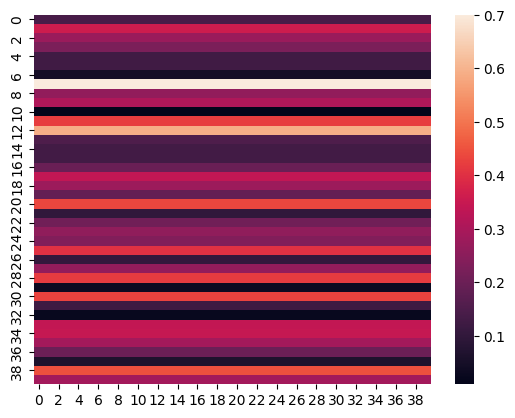

In [12]:
phi_mat = np.outer(np.reshape(data['pheno_probs'],(Ng*Np,1)),np.ones((Ng*Np)))
sns.heatmap(phi_mat)

<Axes: >

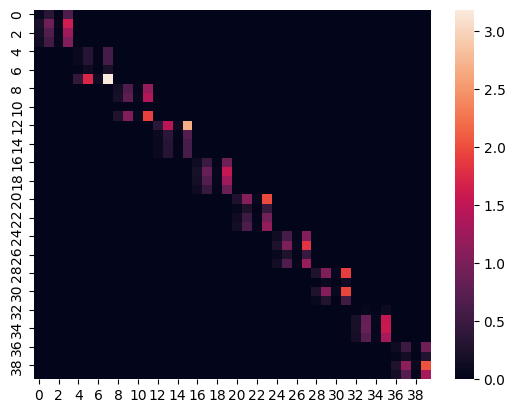

In [13]:
selection_mat = phi_mat * block_dirac * Xk
sns.heatmap(selection_mat)

In [14]:
# # test if selection term is correct or not
# f_test = np.random.rand(Ng,Np)
# f_test = f_test / np.sum(f_test,None)
# matrix_test = selection_mat @ np.reshape(f_test,[Ng*Np,1])

# temp = np.zeros((Ng))
# for g in range(Ng):
#     temp[g] = np.sum(f_test[g,:] * X)
# temp2 = np.zeros((Ng,Np))
# for g in range(Ng):
#     for p in range(Np):
#         temp2[g,p] = data['pheno_probs'][g,p] * temp[g]
# sum_test = np.reshape(temp2,[Ng*Np,1])

# plt.scatter(matrix_test,sum_test)

<Axes: >

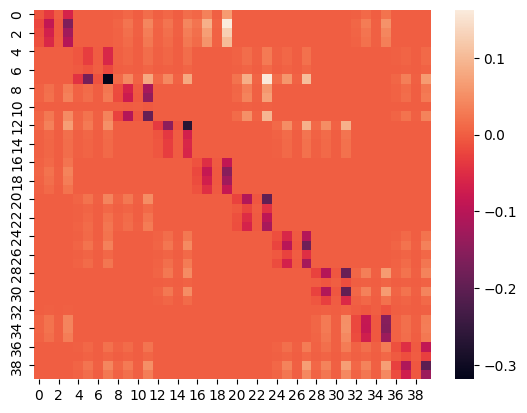

In [15]:
n_neighbors = np.sum(data['A'],axis=0)
inverse_neighbor_mat = data['A'] / n_neighbors
mu_rate_mat = data['mu'] * inverse_neighbor_mat - np.diag(np.sum(data['mu'] * inverse_neighbor_mat,axis=0))
expanded_mu_mat = np.kron(mu_rate_mat,np.ones((Np,Np)))
complete_mutation_mat = phi_mat * expanded_mu_mat * Xk
sns.heatmap(complete_mutation_mat)

In [16]:
np.sum(mu_rate_mat,axis=0)

array([-6.93889390e-18,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -6.93889390e-18, -1.38777878e-17,
       -6.93889390e-18,  0.00000000e+00])

<Axes: >

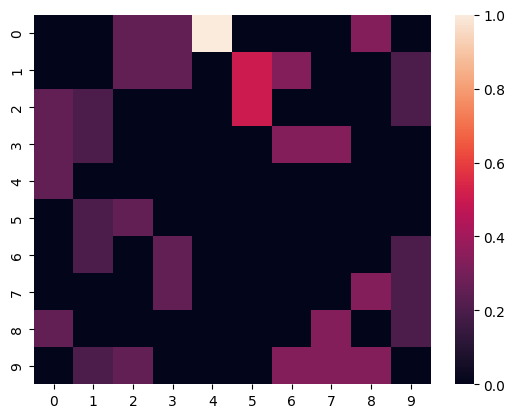

In [17]:
sns.heatmap(inverse_neighbor_mat)

In [18]:
# compute full matrix with both selection and mutation terms
rhs_mat = selection_mat + complete_mutation_mat

# perform eigenvalue decomposition
eig_decomp = np.linalg.eig(rhs_mat)
eigvecs = eig_decomp.eigenvectors

# equilibrium frequency vec is the eigenvector with all elements having the same sign
ind_list = np.where(np.sum(eigvecs > 0,axis=0) == Ng * Np)[0]
if len(np.where(np.sum(eigvecs > 0,axis=0) == Ng * Np)[0]) == 0:
    ind = np.where(np.sum(eigvecs > 0,axis=0) == 0)[0][0]
else:
    ind = ind_list[0]
f_eq_unnormalized = eigvecs[:,ind_list[0]]
Xbar_theory = eig_decomp.eigenvalues[ind]

# verify that f_eq and mean fitness are real
if np.sum(np.isreal(f_eq_unnormalized)) < 40:
    print('Equilibrium vector may have nonzero imaginary parts.')
    print(f_eq_unnormalized)
f_eq = np.real(f_eq_unnormalized) / np.sum(np.real(f_eq_unnormalized))

if not np.isreal(Xbar_theory):
    print('Mean fitness may have nonzero imaginary part.')
    print(Xbar_theory)
Xbar_theory = np.real(Xbar_theory)
    

In [19]:
# reshape freq_timeseries
reshaped_freq_timeseries = np.reshape(data['freq_timeseries'],[Ng*Np,data['T']])

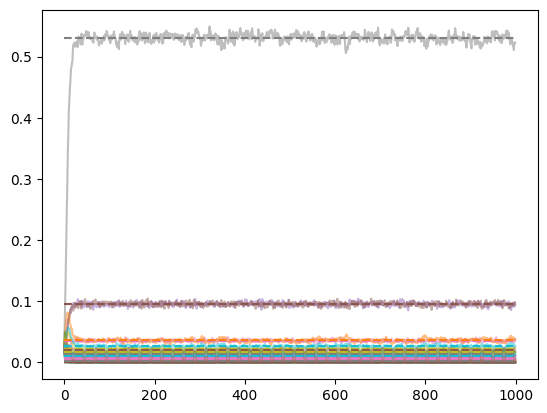

In [21]:
plt.plot(reshaped_freq_timeseries.T,alpha=0.5)
plt.plot(np.outer(np.ones((data['T'])),f_eq),'--')